# model_2-Multiple Linear Regression
Desarrollamos un modelo de MLR eliminando ceros y valores atipicos usando DBSCAN

In [116]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option("display.max_columns", None)

from scipy import stats
import scipy
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.preprocessing import MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score, make_scorer
import numpy as np

In [117]:
#carga de los dos dataset previamente tratados (train y test)
df_train = pd.read_excel('/content/drive/MyDrive/Personal/test_bancolombia/Prueba Modelo_data/train.xlsx', index_col=0)
df_test = pd.read_excel('/content/drive/MyDrive/Personal/test_bancolombia/Prueba Modelo_data/test.xlsx', index_col=0)

In [118]:
#carga dataset resultados
df_base_evaluada = pd.read_csv("/content/drive/MyDrive/Personal/test_bancolombia/Prueba Modelo_data/base_evaluada.csv")

In [119]:
df_base_evaluada.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5385 entries, 0 to 5384
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   id                   5385 non-null   int64
 1   valor_total_avaluo   5385 non-null   int64
dtypes: int64(2)
memory usage: 84.3 KB


In [120]:
df_base_evaluada.head()

,id,valor_total_avaluo
0,2,200000000
1,9,200000000
2,16,200000000
3,25,200000000
4,30,200000000


In [121]:
df_base_evaluada.describe()

,id,valor_total_avaluo
count,5385.000000,5385.0
mean,9252.405757,200000000.0
std,5237.763333,0.0
min,2.000000,200000000.0
25%,4700.000000,200000000.0
50%,9275.000000,200000000.0
75%,13769.000000,200000000.0
max,18324.000000,200000000.0


In [122]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12857 entries, 0 to 12856
Data columns (total 49 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   municipio_inmueble               12857 non-null  object 
 1   tipo_inmueble                    12857 non-null  object 
 2   demanda_interes                  12857 non-null  int64  
 3   alamedas                         12857 non-null  int64  
 4   nivel_equipamiento_comercial     12857 non-null  int64  
 5   observaciones_altura_permitida   12857 non-null  int64  
 6   antejardin                       12857 non-null  object 
 7   indice_ocupacion                 12857 non-null  float64
 8   unidades                         12857 non-null  object 
 9   alcantarillado_en_el_sector      12857 non-null  int64  
 10  acueducto_en_el_sector           12857 non-null  int64  
 11  gas_en_el_sector                 12857 non-null  int64  
 12  energia_en_el_sect

## Eliminar 0's o menores en valor_total_avaluo

In [123]:
train=  df_train.copy()

In [124]:
train = train[train['valor_total_avaluo']>0]

In [125]:
train.shape #reduce la dimension del dataset.

(12697, 49)

## Eliminar 0's y menores en variables de area_total
Estos valores no tienen sentido

In [126]:
train = train[train['area_valorada']>0]

In [127]:
train.shape

(12614, 49)

In [128]:
#guardamos por si necesitamos probar en otro modelo
train.to_excel("/content/drive/MyDrive/Personal/test_bancolombia/Prueba Modelo_data/train_no_zeros_only.xlsx")

## Retirar Outlieres: DBSCAN
Pasaremos un set de todas las variables y revisaremos cuantos datos son outliers, los retiraremos

In [129]:
min_samples = int(len(train)*0.01)
min_samples

126

In [130]:
all_values_test = [
              'demanda_interes',
 'alamedas',
 'nivel_equipamiento_comercial',
 'observaciones_altura_permitida',
 #'antejardin',
 'indice_ocupacion',
 #'unidades',
 'alcantarillado_en_el_sector',
 'acueducto_en_el_sector',
 'gas_en_el_sector',
 'energia_en_el_sector',
 'telefono_en_el_sector',
 'vias_pavimentadas',
 'estrato',
 'arborizacion',
 'ciclo_rutas',
 'sometido_a_propiedad_horizontal',
 'area_valorada',
 'habitaciones',
 'estar_habitacion',
 'cuarto_servicio',
 'closet',
 'sala',
 'bano_privado',
 'bano_social',
 'bano_servicio',
 'cocina',
 'estudio',
 'balcon',
 'terraza',
 'patio_interior',
 'jardin',
 'zona_de_ropas',
 'zona_verde_privada',
 'local',
 'oficina',
 'bodega',
 'area_privada',
 'area_garaje',
 'area_terreno',
 'area_construccion',
 'area_deposito',
 'area_otros',
 'area_libre'
]
all_values_test.append('valor_total_avaluo')

### Definir el valor de epsilon

In [131]:
def knn_epsilon(perm,min_samples):
  scaler = MinMaxScaler()
  #scaler.fit(df)
  norm_series = scaler.fit_transform(perm)
  norm_df = pd.DataFrame(norm_series, columns=perm.columns)
  norm_df.head()
  neighbors = NearestNeighbors(n_neighbors=min_samples)
  neighbors_fit = neighbors.fit(norm_df)
  distances, indices = neighbors_fit.kneighbors(norm_df)

  distances = np.sort(distances, axis=0)
  distances = distances[:,1]
  plt.plot(distances);

  return distances

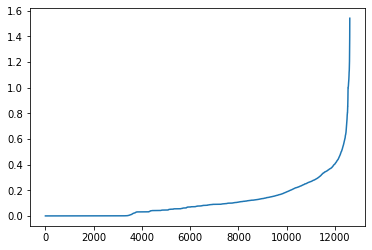

In [132]:
distances = knn_epsilon(train[all_values_test],min_samples)

Text(0.5, 1.0, 'Gráfica de distancia k')

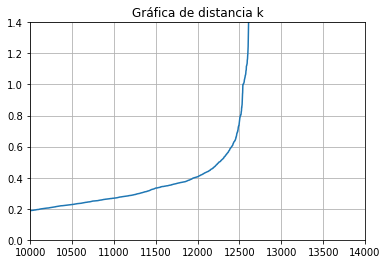

In [133]:
plt.axis([10000, 14000, 0.0, 1.4])
plt.plot(distances)
plt.grid()
plt.title("Gráfica de distancia k")

Text(0.5, 1.0, 'Gráfica de distancia k')

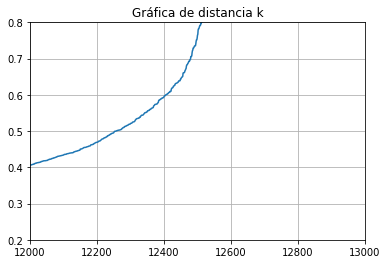

In [134]:
plt.axis([12000, 13000, 0.2, 0.8])
plt.plot(distances)
plt.grid()
plt.title("Gráfica de distancia k")

In [135]:
ep = 0.6

In [136]:
scaler = MinMaxScaler()
norm_series = scaler.fit_transform(train[all_values_test])
norm_df = pd.DataFrame(norm_series, columns=train[all_values_test].columns)
norm_df.head()

,demanda_interes,alamedas,nivel_equipamiento_comercial,observaciones_altura_permitida,indice_ocupacion,alcantarillado_en_el_sector,acueducto_en_el_sector,gas_en_el_sector,energia_en_el_sector,telefono_en_el_sector,vias_pavimentadas,estrato,arborizacion,ciclo_rutas,sometido_a_propiedad_horizontal,area_valorada,habitaciones,estar_habitacion,cuarto_servicio,closet,sala,bano_privado,bano_social,bano_servicio,cocina,estudio,balcon,terraza,patio_interior,jardin,zona_de_ropas,zona_verde_privada,local,oficina,bodega,area_privada,area_garaje,area_terreno,area_construccion,area_deposito,area_otros,area_libre,valor_total_avaluo
0,0.666667,1.0,0.666667,0.00,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.2,1.0,1.0,1.0,0.000139,0.09375,0.0,0.0,0.000000,0.030303,0.000000,0.142857,0.0,0.076923,0.0,0.0,0.000000,0.000000,0.00,0.076923,0.0,0.0,0.0,0.0,0.000949,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000013
1,0.666667,0.0,0.666667,0.00,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.2,1.0,0.0,0.0,0.000242,0.12500,0.0,0.0,0.000000,0.030303,0.083333,0.000000,0.0,0.076923,0.0,0.0,0.111111,0.090909,0.00,0.076923,0.0,0.0,0.0,0.0,0.000000,0.0,0.000049,0.000303,0.0,0.004053,0.0,0.000015
2,0.666667,0.0,1.000000,0.00,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.4,1.0,0.0,1.0,0.000128,0.09375,0.0,0.0,0.136364,0.030303,0.000000,0.071429,0.0,0.076923,0.0,0.0,0.000000,0.000000,0.00,0.076923,0.0,0.0,0.0,0.0,0.000874,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000013
3,0.666667,0.0,0.666667,0.12,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.2,0.0,0.0,0.0,0.000150,0.09375,0.0,0.0,0.000000,0.030303,0.041667,0.071429,0.0,0.076923,0.0,0.0,0.111111,0.000000,0.00,0.076923,0.0,0.0,0.0,0.0,0.000000,0.0,0.000012,0.000209,0.0,0.000000,0.0,0.000014
4,0.666667,0.0,0.333333,0.12,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.4,1.0,0.0,0.0,0.000204,0.09375,0.0,0.0,0.000000,0.030303,0.041667,0.000000,0.0,0.076923,0.0,0.0,0.000000,0.181818,0.25,0.076923,0.0,0.0,0.0,0.0,0.000000,0.0,0.000030,0.000256,0.0,0.000000,0.0,0.000011


In [137]:
model = DBSCAN(eps=ep,min_samples=min_samples)
model_labels = model.fit_predict(norm_df)

In [138]:
train['cluster']  = model_labels

In [139]:
train['cluster'].value_counts(dropna=False)

 2     4172
 1     1747
 0     1509
-1     1320
 5     1040
 7      760
 6      701
 3      582
 10     219
 8      215
 9      180
 4      169
Name: cluster, dtype: int64

In [140]:
#quitemos los atipicos de nuestro dataset original
train = train[train['cluster']>=0]

In [141]:
train.shape

(11294, 50)

In [142]:
train.drop(columns=['cluster'],inplace=True)

In [143]:
train.head()

,municipio_inmueble,tipo_inmueble,demanda_interes,alamedas,nivel_equipamiento_comercial,observaciones_altura_permitida,antejardin,indice_ocupacion,unidades,alcantarillado_en_el_sector,acueducto_en_el_sector,gas_en_el_sector,energia_en_el_sector,telefono_en_el_sector,vias_pavimentadas,estrato,arborizacion,ciclo_rutas,sometido_a_propiedad_horizontal,area_valorada,habitaciones,estar_habitacion,cuarto_servicio,closet,sala,bano_privado,bano_social,bano_servicio,cocina,estudio,balcon,terraza,patio_interior,jardin,zona_de_ropas,zona_verde_privada,local,oficina,bodega,area_privada,area_garaje,area_terreno,area_construccion,area_deposito,area_otros,area_libre,valor_total_avaluo,nivel_servicios,id
0,SOACHA,Casa,2,1,3,0,Aplica,0.0,0,1,1,1,1,1,1,2,1,1,1,53.33,3,0,0,0,1,0,2,0,1,0,0,0,0,0,1,0,0,0,0,53.33,0.00,0.00,0.0,0.0,0.0,0.0,7.199550e+07,5,1
1,SINCELEJO,Casa,2,0,3,0,Aplica,0.0,0,1,1,1,1,1,1,2,1,0,0,92.00,4,0,0,0,1,2,0,0,1,0,0,1,1,0,1,0,0,0,0,0.00,0.00,154.00,92.0,0.0,48.0,0.0,8.709400e+07,5,3
2,CALI,Apartamento,2,0,4,0,Aplica,0.0,0,1,1,1,1,1,1,3,1,0,1,49.13,3,0,0,3,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,49.13,0.00,0.00,0.0,0.0,0.0,0.0,7.615150e+07,5,4
4,TULUA,Casa,2,0,2,3,Aplica,0.0,0,1,1,1,1,1,0,3,1,0,0,78.00,3,0,0,0,1,1,0,0,1,0,0,0,2,1,1,0,0,0,0,0.00,0.00,92.52,77.9,0.0,0.0,0.0,6.120500e+07,5,6
5,ITAGUI,Apartamento,2,0,3,0,Aplica,0.0,0,1,1,1,1,1,1,3,1,0,1,62.44,3,0,0,0,1,2,0,0,1,0,1,0,0,0,1,0,0,0,0,62.44,13.32,0.00,0.0,0.0,0.0,0.0,1.648560e+12,5,7


In [144]:
#guardamos por si necesitamos probar en otro modelo
train.to_excel("/content/drive/MyDrive/Personal/test_bancolombia/Prueba Modelo_data/train_no_zeros_no_out.xlsx")

## Normalizamos datos de train excepto el total_avaluo

In [145]:
all_values_to_pred = all_values_test.copy()

In [146]:
all_values_to_pred.remove('valor_total_avaluo')
print(all_values_to_pred)

['demanda_interes', 'alamedas', 'nivel_equipamiento_comercial', 'observaciones_altura_permitida', 'indice_ocupacion', 'alcantarillado_en_el_sector', 'acueducto_en_el_sector', 'gas_en_el_sector', 'energia_en_el_sector', 'telefono_en_el_sector', 'vias_pavimentadas', 'estrato', 'arborizacion', 'ciclo_rutas', 'sometido_a_propiedad_horizontal', 'area_valorada', 'habitaciones', 'estar_habitacion', 'cuarto_servicio', 'closet', 'sala', 'bano_privado', 'bano_social', 'bano_servicio', 'cocina', 'estudio', 'balcon', 'terraza', 'patio_interior', 'jardin', 'zona_de_ropas', 'zona_verde_privada', 'local', 'oficina', 'bodega', 'area_privada', 'area_garaje', 'area_terreno', 'area_construccion', 'area_deposito', 'area_otros', 'area_libre']


In [147]:
norm_train_y = train.copy()

In [148]:
scaler = MinMaxScaler()
norm_train_y_series = scaler.fit_transform(norm_train_y[all_values_to_pred])
norm_train_y = pd.DataFrame(norm_train_y_series, columns=norm_train_y[all_values_to_pred].columns)
norm_train_y.head()

,demanda_interes,alamedas,nivel_equipamiento_comercial,observaciones_altura_permitida,indice_ocupacion,alcantarillado_en_el_sector,acueducto_en_el_sector,gas_en_el_sector,energia_en_el_sector,telefono_en_el_sector,vias_pavimentadas,estrato,arborizacion,ciclo_rutas,sometido_a_propiedad_horizontal,area_valorada,habitaciones,estar_habitacion,cuarto_servicio,closet,sala,bano_privado,bano_social,bano_servicio,cocina,estudio,balcon,terraza,patio_interior,jardin,zona_de_ropas,zona_verde_privada,local,oficina,bodega,area_privada,area_garaje,area_terreno,area_construccion,area_deposito,area_otros,area_libre
0,0.666667,1.0,0.666667,0.00,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.2,1.0,1.0,1.0,0.000178,0.125000,0.0,0.0,0.000000,0.083333,0.000000,0.181818,0.0,0.125,0.0,0.000000,0.0,0.0,0.000000,0.1,0.0,0.0,0.0,0.0,0.016315,0.000000,0.000000,0.000000,0.0,0.000000,0.0
1,0.666667,0.0,0.666667,0.00,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.2,1.0,0.0,0.0,0.000347,0.166667,0.0,0.0,0.000000,0.083333,0.166667,0.000000,0.0,0.125,0.0,0.000000,0.2,0.2,0.000000,0.1,0.0,0.0,0.0,0.0,0.000000,0.000000,0.002110,0.001044,0.0,0.016652,0.0
2,0.666667,0.0,1.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.4,1.0,0.0,1.0,0.000160,0.125000,0.0,0.0,0.272727,0.083333,0.000000,0.090909,0.0,0.125,0.0,0.000000,0.0,0.0,0.000000,0.1,0.0,0.0,0.0,0.0,0.015030,0.000000,0.000000,0.000000,0.0,0.000000,0.0
3,0.666667,0.0,0.333333,0.12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4,1.0,0.0,0.0,0.000286,0.125000,0.0,0.0,0.000000,0.083333,0.083333,0.000000,0.0,0.125,0.0,0.000000,0.0,0.4,0.333333,0.1,0.0,0.0,0.0,0.0,0.000000,0.000000,0.001267,0.000884,0.0,0.000000,0.0
4,0.666667,0.0,0.666667,0.00,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.4,1.0,0.0,1.0,0.000218,0.125000,0.0,0.0,0.000000,0.083333,0.166667,0.000000,0.0,0.125,0.0,0.166667,0.0,0.0,0.000000,0.1,0.0,0.0,0.0,0.0,0.019102,0.001316,0.000000,0.000000,0.0,0.000000,0.0


In [149]:
norm_train_y['valor_total_avaluo'] = list(train['valor_total_avaluo'])

In [150]:
norm_train_y

,demanda_interes,alamedas,nivel_equipamiento_comercial,observaciones_altura_permitida,indice_ocupacion,alcantarillado_en_el_sector,acueducto_en_el_sector,gas_en_el_sector,energia_en_el_sector,telefono_en_el_sector,vias_pavimentadas,estrato,arborizacion,ciclo_rutas,sometido_a_propiedad_horizontal,area_valorada,habitaciones,estar_habitacion,cuarto_servicio,closet,sala,bano_privado,bano_social,bano_servicio,cocina,estudio,balcon,terraza,patio_interior,jardin,zona_de_ropas,zona_verde_privada,local,oficina,bodega,area_privada,area_garaje,area_terreno,area_construccion,area_deposito,area_otros,area_libre,valor_total_avaluo
0,0.666667,1.0,0.666667,0.00,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.2,1.0,1.0,1.0,0.000178,0.125000,0.00,0.0,0.000000,0.083333,0.000000,0.181818,0.0,0.125,0.0,0.000000,0.0,0.0,0.000000,0.1,0.0,0.0,0.0,0.0,0.016315,0.000000,0.000000,0.000000,0.0,0.000000,0.0,7.199550e+07
1,0.666667,0.0,0.666667,0.00,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.2,1.0,0.0,0.0,0.000347,0.166667,0.00,0.0,0.000000,0.083333,0.166667,0.000000,0.0,0.125,0.0,0.000000,0.2,0.2,0.000000,0.1,0.0,0.0,0.0,0.0,0.000000,0.000000,0.002110,0.001044,0.0,0.016652,0.0,8.709400e+07
2,0.666667,0.0,1.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.4,1.0,0.0,1.0,0.000160,0.125000,0.00,0.0,0.272727,0.083333,0.000000,0.090909,0.0,0.125,0.0,0.000000,0.0,0.0,0.000000,0.1,0.0,0.0,0.0,0.0,0.015030,0.000000,0.000000,0.000000,0.0,0.000000,0.0,7.615150e+07
3,0.666667,0.0,0.333333,0.12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4,1.0,0.0,0.0,0.000286,0.125000,0.00,0.0,0.000000,0.083333,0.083333,0.000000,0.0,0.125,0.0,0.000000,0.0,0.4,0.333333,0.1,0.0,0.0,0.0,0.0,0.000000,0.000000,0.001267,0.000884,0.0,0.000000,0.0,6.120500e+07
4,0.666667,0.0,0.666667,0.00,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.4,1.0,0.0,1.0,0.000218,0.125000,0.00,0.0,0.000000,0.083333,0.166667,0.000000,0.0,0.125,0.0,0.166667,0.0,0.0,0.000000,0.1,0.0,0.0,0.0,0.0,0.019102,0.001316,0.000000,0.000000,0.0,0.000000,0.0,1.648560e+12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11289,0.666667,1.0,0.666667,0.00,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.4,1.0,1.0,1.0,0.000183,0.125000,0.00,0.0,0.272727,0.083333,0.083333,0.090909,0.0,0.125,0.0,0.166667,0.0,0.0,0.000000,0.1,0.0,0.0,0.0,0.0,0.016642,0.001235,0.000000,0.000000,0.0,0.000000,0.0,1.832000e+08
11290,0.666667,1.0,1.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.4,1.0,1.0,1.0,0.000125,0.083333,0.25,0.0,0.181818,0.083333,0.000000,0.090909,0.0,0.125,0.0,0.166667,0.0,0.0,0.000000,0.1,0.0,0.0,0.0,0.0,0.012570,0.000000,0.000000,0.000000,0.0,0.000000,0.0,1.528548e+08
11291,0.666667,0.0,1.000000,0.12,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.4,0.0,0.0,0.0,0.000367,0.208333,0.00,0.0,0.000000,0.083333,0.000000,0.090909,0.0,0.125,0.0,0.000000,0.0,0.0,0.333333,0.1,0.5,0.0,0.0,0.0,0.000000,0.000000,0.001890,0.001096,0.0,0.000000,0.0,2.202480e+08
11292,0.666667,0.0,1.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.4,1.0,0.0,1.0,0.000175,0.125000,0.00,0.0,0.181818,0.083333,0.083333,0.090909,0.0,0.125,0.0,0.000000,0.0,0.0,0.000000,0.1,0.0,0.0,0.0,0.0,0.016131,0.000000,0.000000,0.000000,0.0,0.000000,0.0,1.236518e+08


In [151]:
norm_train_y['valor_total_avaluo'].isna().sum()

0

## MLR 3
Entrenamos con las variables previamente seleccionadas en el primer ejercicio con un dataset normalizado

In [152]:
#Utilizamos todas las variables de area y algunas que demostraron mayor correlación
set_x = [
 'area_privada',
 'area_garaje',
 'area_terreno',
 'area_construccion',
 'area_deposito',
 'area_otros',
 'area_libre',
 'estrato',
 'alamedas',
 'cuarto_servicio',
 'zona_verde_privada',
 'estar_habitacion',
 'acueducto_en_el_sector',
 'bano_social',
 'nivel_equipamiento_comercial'
]

y = 'valor_total_avaluo'

In [153]:
#concatenate values
vars_x = ' + '
vars_x = vars_x.join(set_x)
print(vars_x)

area_privada + area_garaje + area_terreno + area_construccion + area_deposito + area_otros + area_libre + estrato + alamedas + cuarto_servicio + zona_verde_privada + estar_habitacion + acueducto_en_el_sector + bano_social + nivel_equipamiento_comercial


In [154]:
formula_str = y + ' ~ ' + vars_x
print(formula_str)

valor_total_avaluo ~ area_privada + area_garaje + area_terreno + area_construccion + area_deposito + area_otros + area_libre + estrato + alamedas + cuarto_servicio + zona_verde_privada + estar_habitacion + acueducto_en_el_sector + bano_social + nivel_equipamiento_comercial


In [155]:
model = sm.OLS.from_formula(formula_str, data=norm_train_y)

result = model.fit()
result.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     valor_total_avaluo   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.646
Date:                Sun, 20 Jun 2021   Prob (F-statistic):             0.0657
Time:                        22:54:13   Log-Likelihood:            -2.8825e+05
No. Observations:               11294   AIC:                         5.765e+05
Df Residuals:                   11280   BIC:                         5.766e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                     2.919e+09    1.3e+09      2.248      0.025    3.73e+08    5.47e+09
area_privada                  1.805e+09   1.11e+10      0.162      0.871      -2e+10    2.36e+10
area_garaje                   2.415e+09   2.93e+10      0.082      0.934   -5.51e+10    5.99e+10
area_terreno                  3.503e+10   2.23e+10      1.573      0.116   -8.61e+09    7.87e+10
area_construccion             8.412e+10   2.26e+10      3.720      0.000    3.98e+10    1.28e+11
area_deposito                 1.609e+09   4.98e+09      0.323      0.747   -8.16e+09    1.14e+10
area_otros                    1.704e+08   1.27e+10      0.013      0.989   -2.48e+10    2.51e+10
area_libre                    4.297e-06   7.62e-06      0.564      0.573   -1.06e-05    1.92e-05
estrato                      -2.533e+08   1.35e+09     -0.188      0.851   -2.89e+09    2.39e+09
alamedas                     -4.708e+08   6.65e+08     -0.708      0.479   -1.78e+09    8.34e+08
cuarto_servicio              -6.634e+08   1.95e+09     -0.341      0.733   -4.48e+09    3.15e+09
zona_verde_privada           -1.334e+09   3.13e+09     -0.426      0.670   -7.47e+09     4.8e+09
estar_habitacion             -4.572e+08   3.25e+09     -0.141      0.888   -6.83e+09    5.91e+09
acueducto_en_el_sector                0          0        nan        nan           0           0
bano_social                   1.979e+09   4.35e+09      0.455      0.649   -6.54e+09    1.05e+10
nivel_equipamiento_comercial -2.669e+09    1.6e+09     -1.673      0.094    -5.8e+09    4.59e+08
==============================================================================
Omnibus:                    35438.498   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       3399991042.381
Skew:                          49.655   Prob(JB):                         0.00
Kurtosis:                    2689.111   Cond. No.                     9.32e+20
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.4e-38. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Los resultados obtenidos siguen siendo deficientes

Aunque siguen siendo malos resultados
Intentemos una MLR con todos los valores numéricos y luego filtremos los que nos sean significativos en otro ejercicio


### normalizo testeo

In [156]:
scaler = MinMaxScaler()
norm_series = scaler.fit_transform(df_test[all_values_to_pred])
norm_df_test = pd.DataFrame(norm_series, columns=df_test[all_values_to_pred].columns)
norm_df_test.head()

,demanda_interes,alamedas,nivel_equipamiento_comercial,observaciones_altura_permitida,indice_ocupacion,alcantarillado_en_el_sector,acueducto_en_el_sector,gas_en_el_sector,energia_en_el_sector,telefono_en_el_sector,vias_pavimentadas,estrato,arborizacion,ciclo_rutas,sometido_a_propiedad_horizontal,area_valorada,habitaciones,estar_habitacion,cuarto_servicio,closet,sala,bano_privado,bano_social,bano_servicio,cocina,estudio,balcon,terraza,patio_interior,jardin,zona_de_ropas,zona_verde_privada,local,oficina,bodega,area_privada,area_garaje,area_terreno,area_construccion,area_deposito,area_otros,area_libre
0,0.333333,0.0,0.333333,0.000000,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.000861,0.238095,0.0,0.0,0.000000,0.090909,0.000000,0.181818,0.0,0.166667,0.0,0.333333,0.00,0.4,0.0,0.2,0.0,0.0,0.0,0.0,0.000000,0.0,0.000030,0.185680,0.0,0.0,0.0
1,0.333333,0.0,0.333333,0.133333,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000344,0.095238,0.0,0.0,0.000000,0.181818,0.166667,0.000000,0.0,0.166667,0.0,0.000000,0.00,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.000000,0.0,0.000034,0.074082,0.0,0.0,0.0
2,0.666667,1.0,0.666667,0.000000,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.2,1.0,1.0,1.0,0.000187,0.095238,0.0,0.0,0.117647,0.090909,0.000000,0.090909,0.0,0.083333,0.0,0.000000,0.00,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.000005,0.0,0.000000,0.000000,0.0,0.0,0.0
3,0.666667,1.0,0.333333,0.000000,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.6,1.0,0.0,1.0,0.007256,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000213,0.0,0.000000,0.000000,0.0,0.0,0.0
4,0.666667,0.0,0.333333,0.133333,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.4,0.0,0.0,0.0,0.000368,0.142857,0.0,0.0,0.176471,0.090909,0.083333,0.090909,0.0,0.083333,0.0,0.000000,0.25,0.2,0.0,0.1,0.0,0.0,0.0,0.0,0.000000,0.0,0.000029,0.079050,0.0,0.0,0.0


In [157]:
#exportar resultados
df_test['valor_total_avaluo_pred'] = result.predict(norm_df_test[all_values_to_pred])

In [158]:
df_tojoin= df_test[['valor_total_avaluo_pred','id']]

In [159]:
response = df_base_evaluada.merge(df_tojoin, on='id')

In [160]:
response.head()

,id,valor_total_avaluo,valor_total_avaluo_pred
0,2,200000000,1.800950e+10
1,9,200000000,8.262493e+09
2,16,200000000,7.984004e+08
3,25,200000000,1.407296e+09
4,30,200000000,8.758780e+09


In [161]:
response.drop(columns=['valor_total_avaluo '], inplace=True)

In [162]:
response.head()

,id,valor_total_avaluo_pred
0,2,1.800950e+10
1,9,8.262493e+09
2,16,7.984004e+08
3,25,1.407296e+09
4,30,8.758780e+09


In [163]:
response.rename(columns={'valor_total_avaluo_pred':'valor_total_avaluo '}, inplace=True)#conserva nombre original

In [164]:
response

,id,valor_total_avaluo
0,2,1.800950e+10
1,9,8.262493e+09
2,16,7.984004e+08
3,25,1.407296e+09
4,30,8.758780e+09
...,...,...
5380,18316,1.873388e+08
5381,18317,6.277990e+09
5382,18318,1.170345e+09
5383,18319,3.307098e+08


In [165]:
response.columns.isna().sum()

0

In [166]:
response.columns.to_list()

['id', 'valor_total_avaluo ']

In [167]:
#exportar resultado
response.to_csv("/content/drive/MyDrive/Personal/test_bancolombia/desarrollo/04_results/MLR_3/base_evaluada.csv", header=True)

## MLR 4
Intentemos con una permutacion mas 

In [168]:
#se excluyen altas concentraciones de 0's
set_x_2 = [
 'area_privada',
 'area_garaje',
 'area_terreno',
 'area_construccion',
 'estrato',
 'estar_habitacion',
 'acueducto_en_el_sector',
 'bano_social',
 'nivel_equipamiento_comercial'
]

y = 'valor_total_avaluo'

In [169]:
#concatenate values
vars_x = ' + '
vars_x = vars_x.join(set_x_2)
print(vars_x)

area_privada + area_garaje + area_terreno + area_construccion + estrato + estar_habitacion + acueducto_en_el_sector + bano_social + nivel_equipamiento_comercial


In [170]:
formula_str = y + ' ~ ' + vars_x
print(formula_str)

valor_total_avaluo ~ area_privada + area_garaje + area_terreno + area_construccion + estrato + estar_habitacion + acueducto_en_el_sector + bano_social + nivel_equipamiento_comercial


In [171]:
model = sm.OLS.from_formula(formula_str, data=norm_train_y)

result2 = model.fit()
result2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     valor_total_avaluo   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     2.554
Date:                Sun, 20 Jun 2021   Prob (F-statistic):            0.00885
Time:                        22:54:13   Log-Likelihood:            -2.8825e+05
No. Observations:               11294   AIC:                         5.765e+05
Df Residuals:                   11285   BIC:                         5.766e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                     2.962e+09   1.28e+09      2.311      0.021     4.5e+08    5.47e+09
area_privada                  1.188e+08   1.08e+10      0.011      0.991    -2.1e+10    2.12e+10
area_garaje                   2.834e+09   2.93e+10      0.097      0.923   -5.46e+10    6.03e+10
area_terreno                  3.479e+10   2.22e+10      1.563      0.118   -8.83e+09    7.84e+10
area_construccion             8.414e+10   2.26e+10      3.722      0.000    3.98e+10    1.28e+11
estrato                      -4.282e+08   1.23e+09     -0.348      0.728   -2.84e+09    1.99e+09
estar_habitacion             -7.362e+08    3.2e+09     -0.230      0.818   -7.02e+09    5.54e+09
acueducto_en_el_sector        2.254e-05   8.41e-06      2.680      0.007    6.06e-06     3.9e-05
bano_social                   1.557e+09   4.32e+09      0.360      0.719   -6.91e+09       1e+10
nivel_equipamiento_comercial -2.705e+09   1.59e+09     -1.701      0.089   -5.82e+09    4.12e+08
==============================================================================
Omnibus:                    35439.361   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       3400519470.186
Skew:                          49.658   Prob(JB):                         0.00
Kurtosis:                    2689.320   Cond. No.                     1.86e+20
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.78e-37. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Seguimos teniendo malos resultados, en otro notebook se prueba con un nuevo modelo

In [172]:
#exportar resultados
df_test['valor_total_avaluo_pred'] = result2.predict(norm_df_test[all_values_to_pred])

In [173]:
df_tojoin= df_test[['valor_total_avaluo_pred','id']]

In [174]:
response2 = df_base_evaluada.merge(df_tojoin, on='id')

In [175]:
response2.head()

,id,valor_total_avaluo,valor_total_avaluo_pred
0,2,200000000,1.796766e+10
1,9,200000000,8.294786e+09
2,16,200000000,1.214457e+09
3,25,200000000,1.803399e+09
4,30,200000000,8.682848e+09


In [176]:
response2.drop(columns=['valor_total_avaluo '], inplace=True)

In [177]:
response2.head()

,id,valor_total_avaluo_pred
0,2,1.796766e+10
1,9,8.294786e+09
2,16,1.214457e+09
3,25,1.803399e+09
4,30,8.682848e+09


In [178]:
response2.rename(columns={'valor_total_avaluo_pred':'valor_total_avaluo '}, inplace=True)#conserva nombre original

In [179]:
response2

,id,valor_total_avaluo
0,2,1.796766e+10
1,9,8.294786e+09
2,16,1.214457e+09
3,25,1.803399e+09
4,30,8.682848e+09
...,...,...
5380,18316,9.038551e+08
5381,18317,6.139506e+09
5382,18318,1.046013e+09
5383,18319,2.293017e+08


In [180]:
response2.columns.isna().sum()

0

In [181]:
response2.columns.to_list()

['id', 'valor_total_avaluo ']

In [182]:
#exportar resultado
#response2.to_csv("/content/drive/MyDrive/Personal/test_bancolombia/desarrollo/04_results/MLR_4/base_evaluada.csv", header=True)

In [1]:
%%shell
jupyter nbconvert --to html '/content/drive/MyDrive/Personal/test_bancolombia/desarrollo/03_Modelado/model3-4-MLR not_zeros.ipynb'

[NbConvertApp] Converting notebook /content/drive/MyDrive/Personal/test_bancolombia/desarrollo/03_Modelado/model3-4-MLR not_zeros.ipynb to html
[NbConvertApp] Writing 432799 bytes to /content/drive/MyDrive/Personal/test_bancolombia/desarrollo/03_Modelado/model3-4-MLR not_zeros.html
